# Approach

We have a a utility called download_data.py. 

Usage: python download_data.py "red hat fedora" 100 ./data/rh

that will download the top 100 image searches for the term "red hat fedora" and store them in ./data/rh

The first attempt is to classify ibm vs red hat images. I used gthumb [https://wiki.gnome.org/Apps/Gthumb] to select relevant images (and sometimes crop them).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import torch

In [4]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Loading

We'll be using fastai's built-in dataloaders

In [5]:
bs = 64 #batch size

In [6]:
image_path = '../data/'

In [7]:
data = ImageDataBunch.from_folder(image_path,
                                  valid_pct = 0.20,
                                  test = '../summit_data/test',
                                  ds_tfms = get_transforms(),
                                  size = 224,
                                  bs = bs,
                                  seed = 1024)

In [ ]:
data.show_batch(rows=3)

In [9]:
??get_transforms

## Load pre-trained model (resnet)

In [20]:
model = cnn_learner(data, models.resnet34, metrics=accuracy)

In [21]:
model.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [22]:
model.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.627432,0.409773,0.776316,00:07
1,0.445733,0.283344,0.868421,00:07
2,0.367778,0.286249,0.907895,00:08
3,0.305907,0.290226,0.934211,00:07


In [23]:
import numpy as np
print(np.unique(data.train_ds.y.items, return_counts=True))
print(np.unique(data.valid_ds.y.items, return_counts=True))

(array([0, 1]), array([162, 143]))
(array([0, 1]), array([41, 35]))


In [24]:
model.unfreeze()
model.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.283202,0.345598,0.881579,00:07


In [25]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


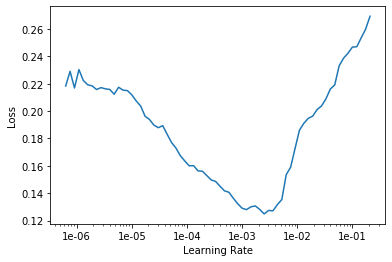

In [26]:
model.recorder.plot()

In [27]:
model.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.179365,0.306575,0.894737,00:07
1,0.127692,0.367784,0.907895,00:08


In [28]:
model.freeze()

In [29]:
model.save('resnet-ibm-rh')

## Interpretation on validation

In [30]:
interp = ClassificationInterpretation.from_learner(model)

In [31]:
losses, idxs = interp.top_losses()

In [32]:
assert(len(data.valid_ds)==len(losses)==len(idxs))

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))

TODO:

* Confirm the titles - should be prediction / label / loss / pred score (between 0 and 1)

* Confirm heat activation maps calculation - should be from filters in convolutions

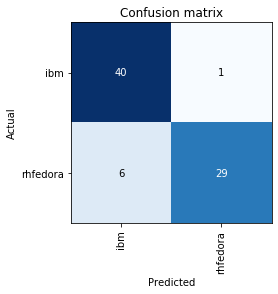

In [34]:
interp.plot_confusion_matrix()

## Make predictions on summit images

In [35]:
test_preds = get_preds(model.model, data.test_dl)

In [36]:
len(test_preds[0])

21

In [37]:
data.train_ds.classes

['ibm', 'rhfedora']

In [38]:
torch.softmax(test_preds[0], dim=1)[:,0]

tensor([0.8016, 0.7957, 0.1219, 0.9999, 0.3056, 0.9762, 0.9682, 0.4194, 0.4906,
        0.9990, 0.0378, 0.7338, 0.9805, 0.9165, 0.9762, 0.9996, 0.9244, 0.9750,
        1.0000, 0.9998, 0.1695])

In [39]:
np.where((torch.softmax(test_preds[0], dim=1)[:,0]).detach().numpy() < 0.5)

(array([ 2,  4,  7,  8, 10, 20]),)

In [ ]:
data.test_ds.x[6]

In [ ]:
data.test_ds.x[10]

In [ ]:
data.test_ds.x[12]

In [ ]:
data.test_ds.x[17]